In [1]:
# Importing libraries. 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = 'fruits_dataset'
classes = os.listdir(data_dir)

In [3]:
# Performing Image Transformations. 
train_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [4]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 9124


In [5]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


In [6]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Avocado (2)


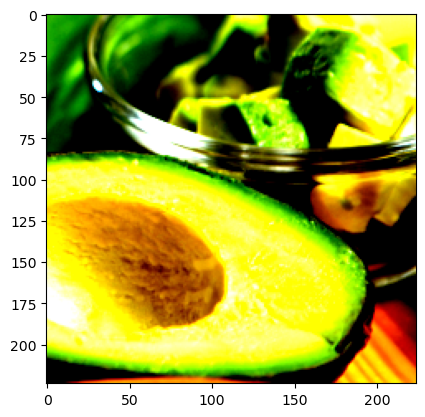

In [7]:
show_image(*dataset[200])

In [8]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [9]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(7756, 456, 912)

In [10]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


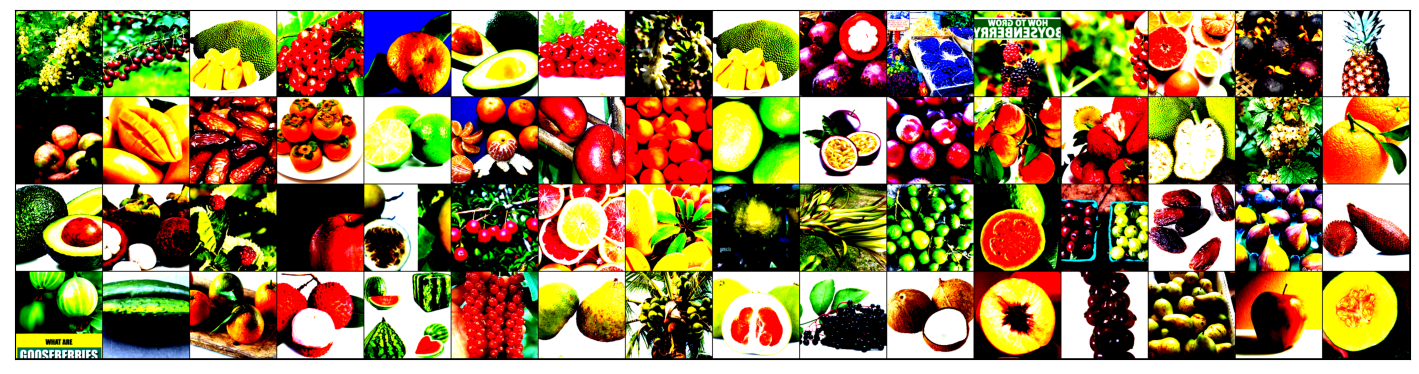

In [11]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [12]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)
        return correct_3.mul_(1.0 / batch_size)


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [15]:
input_size = 3*224*224
output_size = 55

In [16]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
# Convolutional Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.conv9 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.conv10 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.conv11 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
        )
        
        # Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384 * 7 * 7, 4096),
            nn.Dropout(0.5),  # Dropout Layer
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.Dropout(0.4),  # Dropout Layer
        )
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 120),
            nn.Dropout(0.5),  # Dropout Layer
        )
        self.fc4 = nn.Linear(120, num_classes)  # Output layer

    def forward(self, x):
        x = self.pool(self.conv3(self.conv2(self.conv1(x))))
        x = self.pool(self.conv5(self.conv4(x)))
        x = self.pool(self.conv7(self.conv6(x)))
        x = self.pool(self.conv10(self.conv9(self.conv8(x))))
        x = self.pool(self.conv11(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        return x


In [17]:
# Model print
num_classes = 55
model = ConvolutionalNetwork(num_classes)
#model.cuda()

In [18]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 224, 224])
out.shape: torch.Size([64, 55])
out[0]: tensor([ 0.1625,  0.1168, -0.0085, -0.1462, -0.2034,  0.2385, -0.1019, -0.0242,
         0.2900,  0.3743,  0.2668, -0.1079, -0.4530, -0.0712,  0.3196,  0.0711,
         0.3442, -0.3311, -0.1694, -0.2197,  0.2377,  0.4680,  0.2926, -0.2538,
         0.2366,  0.1293, -0.3444,  0.0302,  0.4060, -0.0516,  0.0447,  0.1618,
        -0.1125, -0.0679, -0.0657,  0.4253, -0.1078,  0.0343,  0.2457,  0.1900,
        -0.1725, -0.6195, -0.5524, -0.2536,  0.1690, -0.4119, -0.6418,  0.2534,
         0.1642, -0.1261,  0.0765, -0.2492,  0.3296, -0.2763, -0.2050],
       grad_fn=<SelectBackward0>)


In [19]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5),

In [20]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_drop_period, gamma=lr_drop_factor)
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        scheduler.step()  # Adjust learning rate
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [21]:
model = to_device(model, device)

In [22]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 4.008342742919922, 'val_acc': 0.060546875}]

In [23]:
print(test_size)
num_epochs = 110
optimizer = torch.optim.SGD
momentum = 0.90
lr = 0.001
lr_drop_period = 50
lr_drop_factor = 0.2
epochs = 110
l2_reg = 0.0005

912


In [24]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, optimizer)

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.0121, val_loss: 3.9371, val_acc: 0.1406


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.9174, val_loss: 3.8055, val_acc: 0.2090


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.7860, val_loss: 3.6604, val_acc: 0.2285


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.6768, val_loss: 3.5382, val_acc: 0.2598


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.5868, val_loss: 3.4675, val_acc: 0.2676


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [5], train_loss: 3.5117, val_loss: 3.3666, val_acc: 0.2754


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [6], train_loss: 3.4419, val_loss: 3.3255, val_acc: 0.3008


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.3831, val_loss: 3.2376, val_acc: 0.3184


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [8], train_loss: 3.3111, val_loss: 3.1865, val_acc: 0.4121


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.2362, val_loss: 3.1134, val_acc: 0.4082


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [10], train_loss: 3.1894, val_loss: 3.0362, val_acc: 0.4727


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [11], train_loss: 3.1380, val_loss: 2.9664, val_acc: 0.4551


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [12], train_loss: 3.0964, val_loss: 2.9500, val_acc: 0.4980


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [13], train_loss: 3.0321, val_loss: 2.9110, val_acc: 0.4902


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [14], train_loss: 2.9990, val_loss: 2.8390, val_acc: 0.4863


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [15], train_loss: 2.9397, val_loss: 3.0022, val_acc: 0.4453


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [16], train_loss: 2.9209, val_loss: 2.8347, val_acc: 0.4785


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [17], train_loss: 2.8945, val_loss: 2.8068, val_acc: 0.5039


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [18], train_loss: 2.8436, val_loss: 2.7557, val_acc: 0.5352


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [19], train_loss: 2.8002, val_loss: 2.7615, val_acc: 0.4648


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [20], train_loss: 2.7744, val_loss: 2.7836, val_acc: 0.5195


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [21], train_loss: 2.7389, val_loss: 2.6856, val_acc: 0.5176


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [22], train_loss: 2.7130, val_loss: 2.7249, val_acc: 0.5137


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [23], train_loss: 2.6970, val_loss: 2.7939, val_acc: 0.4570


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [24], train_loss: 2.6716, val_loss: 2.9584, val_acc: 0.4668


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [25], train_loss: 2.6291, val_loss: 2.5521, val_acc: 0.5703


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [26], train_loss: 2.5943, val_loss: 2.6500, val_acc: 0.5176


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [27], train_loss: 2.5782, val_loss: 2.5576, val_acc: 0.5410


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [28], train_loss: 2.5244, val_loss: 2.4820, val_acc: 0.5488


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [29], train_loss: 2.5270, val_loss: 2.5801, val_acc: 0.5215


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [30], train_loss: 2.4983, val_loss: 2.4376, val_acc: 0.5820


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [31], train_loss: 2.4557, val_loss: 2.6142, val_acc: 0.5391


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [32], train_loss: 2.4272, val_loss: 2.4718, val_acc: 0.5801


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [33], train_loss: 2.3950, val_loss: 2.4438, val_acc: 0.5840


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [34], train_loss: 2.3738, val_loss: 2.5899, val_acc: 0.5332


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [35], train_loss: 2.3563, val_loss: 3.7309, val_acc: 0.4062


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [36], train_loss: 2.3181, val_loss: 2.5110, val_acc: 0.5508


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [37], train_loss: 2.3054, val_loss: 2.5812, val_acc: 0.5781


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [38], train_loss: 2.2697, val_loss: 2.4648, val_acc: 0.5430


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [39], train_loss: 2.2628, val_loss: 2.6485, val_acc: 0.5410


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [40], train_loss: 2.2325, val_loss: 2.5107, val_acc: 0.5703


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [41], train_loss: 2.1903, val_loss: 2.5759, val_acc: 0.5488


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [42], train_loss: 2.1584, val_loss: 2.2510, val_acc: 0.6289


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [43], train_loss: 2.1467, val_loss: 2.3643, val_acc: 0.6230


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [44], train_loss: 2.1406, val_loss: 2.3977, val_acc: 0.5977


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [45], train_loss: 2.0973, val_loss: 2.9942, val_acc: 0.5234


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [46], train_loss: 2.0852, val_loss: 2.4573, val_acc: 0.5957


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [47], train_loss: 2.0475, val_loss: 2.2761, val_acc: 0.6211


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [48], train_loss: 2.0619, val_loss: 2.3265, val_acc: 0.6074


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [49], train_loss: 2.0244, val_loss: 3.3312, val_acc: 0.4434


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [50], train_loss: 1.9459, val_loss: 1.9735, val_acc: 0.6719


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [51], train_loss: 1.9406, val_loss: 1.9620, val_acc: 0.6758


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [52], train_loss: 1.8915, val_loss: 1.9619, val_acc: 0.6973


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [53], train_loss: 1.9102, val_loss: 1.9525, val_acc: 0.6797


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [54], train_loss: 1.9058, val_loss: 1.9658, val_acc: 0.6719


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [55], train_loss: 1.8856, val_loss: 1.9456, val_acc: 0.6836


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [56], train_loss: 1.8766, val_loss: 1.9969, val_acc: 0.6758


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [57], train_loss: 1.8752, val_loss: 1.9566, val_acc: 0.6855


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [58], train_loss: 1.8800, val_loss: 1.9506, val_acc: 0.6836


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [59], train_loss: 1.8650, val_loss: 1.9629, val_acc: 0.6660


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [60], train_loss: 1.8670, val_loss: 1.9378, val_acc: 0.6758


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [61], train_loss: 1.8670, val_loss: 1.9446, val_acc: 0.6895


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [62], train_loss: 1.8540, val_loss: 1.9281, val_acc: 0.6836


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [63], train_loss: 1.8416, val_loss: 1.9098, val_acc: 0.6953


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [64], train_loss: 1.8269, val_loss: 1.9041, val_acc: 0.7012


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [65], train_loss: 1.8268, val_loss: 1.9049, val_acc: 0.7070


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [66], train_loss: 1.8295, val_loss: 1.8986, val_acc: 0.7188


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [67], train_loss: 1.8093, val_loss: 1.9238, val_acc: 0.6914


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [68], train_loss: 1.8139, val_loss: 2.0000, val_acc: 0.6816


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [69], train_loss: 1.8079, val_loss: 1.8832, val_acc: 0.7188


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [70], train_loss: 1.8066, val_loss: 1.8815, val_acc: 0.7305


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [71], train_loss: 1.7914, val_loss: 1.8814, val_acc: 0.7012


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [72], train_loss: 1.8132, val_loss: 1.9286, val_acc: 0.6777


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [73], train_loss: 1.7854, val_loss: 1.9337, val_acc: 0.6836


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [74], train_loss: 1.7860, val_loss: 1.9359, val_acc: 0.7031


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [75], train_loss: 1.7677, val_loss: 1.9155, val_acc: 0.6953


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [76], train_loss: 1.7753, val_loss: 1.8511, val_acc: 0.7109


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [77], train_loss: 1.7622, val_loss: 1.8960, val_acc: 0.6758


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [78], train_loss: 1.7616, val_loss: 1.8570, val_acc: 0.7012


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [79], train_loss: 1.7538, val_loss: 1.8583, val_acc: 0.7227


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [80], train_loss: 1.7573, val_loss: 1.8888, val_acc: 0.7070


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [81], train_loss: 1.7364, val_loss: 1.8914, val_acc: 0.6875


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [82], train_loss: 1.7372, val_loss: 1.8323, val_acc: 0.7227


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [83], train_loss: 1.7247, val_loss: 1.8353, val_acc: 0.7207


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [84], train_loss: 1.7067, val_loss: 1.9145, val_acc: 0.7285


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [85], train_loss: 1.7093, val_loss: 1.8343, val_acc: 0.6875


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [86], train_loss: 1.7127, val_loss: 1.8734, val_acc: 0.7090


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [87], train_loss: 1.7115, val_loss: 1.8649, val_acc: 0.6875


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [88], train_loss: 1.6871, val_loss: 1.8461, val_acc: 0.7168


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [89], train_loss: 1.7133, val_loss: 1.8805, val_acc: 0.7090


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [90], train_loss: 1.6984, val_loss: 1.9117, val_acc: 0.7031


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [91], train_loss: 1.6968, val_loss: 1.8657, val_acc: 0.7090


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [92], train_loss: 1.6727, val_loss: 1.8153, val_acc: 0.7109


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [93], train_loss: 1.6812, val_loss: 1.8593, val_acc: 0.6641


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [94], train_loss: 1.6667, val_loss: 1.9134, val_acc: 0.6934


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [95], train_loss: 1.6600, val_loss: 1.8685, val_acc: 0.7246


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [96], train_loss: 1.6682, val_loss: 1.8969, val_acc: 0.7168


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [97], train_loss: 1.6445, val_loss: 1.9195, val_acc: 0.7109


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [98], train_loss: 1.6511, val_loss: 1.9050, val_acc: 0.7031


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [99], train_loss: 1.6511, val_loss: 1.8243, val_acc: 0.7148


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [100], train_loss: 1.6188, val_loss: 1.7547, val_acc: 0.7227


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [101], train_loss: 1.6105, val_loss: 1.7409, val_acc: 0.7344


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [102], train_loss: 1.6248, val_loss: 1.7499, val_acc: 0.7422


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [103], train_loss: 1.6036, val_loss: 1.7495, val_acc: 0.7207


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [104], train_loss: 1.5970, val_loss: 1.7524, val_acc: 0.7402


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [105], train_loss: 1.5967, val_loss: 1.7621, val_acc: 0.7207


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [106], train_loss: 1.6121, val_loss: 1.7551, val_acc: 0.7441


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [107], train_loss: 1.5981, val_loss: 1.7432, val_acc: 0.7246


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [108], train_loss: 1.6014, val_loss: 1.7579, val_acc: 0.7500


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch [109], train_loss: 1.5891, val_loss: 1.7550, val_acc: 0.7324


In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

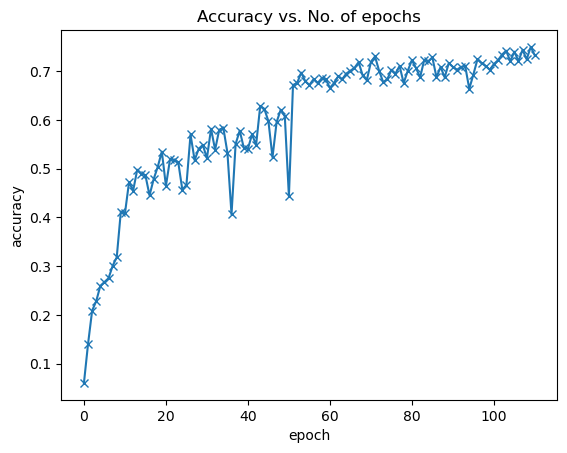

In [26]:
plot_accuracies(history)

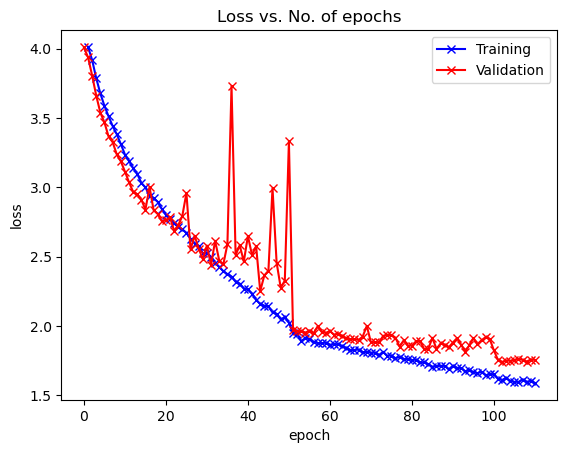

In [27]:
plot_losses(history)

In [28]:
evaluate(model, test_loader)

{'val_loss': 1.6531835794448853, 'val_acc': 0.7541666626930237}

In [29]:
torch.save(model, 'entire_model.pth')